<a href="https://colab.research.google.com/github/mukamal/sentiment-analysis-twitter/blob/main/sentiment_analysis_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

# Download tweets.csv from github
# If the tweets.csv file does not exist in the colab environment
if [[ ! -f ./tweets.csv ]]; then 
   # download tweets.csv file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/mukamal/data/main/tweets.csv   
fi

# vefify tweets.csv exits in the colab env - should not print an error message
ls tweets.csv

  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=931adfa1b92a043dd671c353c80e30dbe39a2d47789f9aa8b7ce0b88c7b89c62
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
tweets.csv


--2021-04-23 01:11:00--  https://raw.githubusercontent.com/mukamal/data/main/tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13727793 (13M) [text/plain]
Saving to: ‘tweets.csv’

     0K .......... .......... .......... .......... ..........  0% 15.1M 1s
    50K .......... .......... .......... .......... ..........  0% 74.6M 1s
   100K .......... .......... .......... .......... ..........  1% 24.0M 1s
   150K .......... .......... .......... .......... ..........  1% 37.0M 0s
   200K .......... .......... .......... .......... ..........  1% 41.2M 0s
   250K .......... .......... .......... .......... ..........  2% 32.4M 0s
   300K .......... .......... .......... .......... ..........  2% 41.5M 0s
   350K .......... .......... .......... ......

In [2]:
# import statements
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
tweets_df = spark.read.format("csv").option("header", "true").load("tweets.csv")
tweets_df.take(5)
tweets_df_1=tweets_df

In [4]:
enable_grid = True

# Sentiment Analysis
 The tweets.csv file contains the following columns:
- target: the polarity of the tweet (0 = negative, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)


Read tweets.csv into a spark dataframe named `tweets_df`. Drop all columns except target and text.  Transform the target column such that a negative sentiment is equal to 0 and a positive sentiment is equal to 1.  Determine and print the percentage of positive and negative tweets in the dataframe.

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

tweets_df_new = tweets_df_1.withColumn("target_float", tweets_df_1["target"].cast(FloatType()))
tweets_df_new=tweets_df_new.withColumn('target',F.when(tweets_df_new.target_float==4,1).otherwise(0))
tweets_df=tweets_df_new.drop('id','date','flag','user','target_float')

#tweets_df.groupBy("target").count().show()
print('Percentage of positive tweets:',100*tweets_df[tweets_df.target==1].count()/tweets_df.count(),'%')
print('Percentage of negative tweets:',100*tweets_df[tweets_df.target==0].count()/tweets_df.count(),'%')


Percentage of positive tweets: 50.0 %
Percentage of negative tweets: 50.0 %


In [6]:
tweets_pd = tweets_df.toPandas()
display(tweets_pd.head())
print(tweets_pd.shape)

,target,text
0,1,I LOVE @Health4UandPets u guys r the best!!
1,1,im meeting up with one of my besties tonight! ...
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
3,1,Being sick can be really cheap when it hurts t...
4,1,@LovesBrooklyn2 he has that effect on everyone


(100000, 2)


Pre-process the data by creating a pipeline named `tweets_pre_proc_pipe`. Pipeline to tokenize, remove stop words, and do a TF-IDF transformation.  
Fit and execute pipeline, and create a new dataframe named `tweets_pre_proc_df`.  Print the shape of the resulting TF-IDF data.

In [7]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import IDF
from pyspark.ml.feature import StopWordsRemover
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()


sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")


tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("text")\
  .setOutputCol("words")

#choose vocabSize
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**14)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

tweets_pre_proc_pipe = Pipeline(stages=[tokenizer, sw_filter, cv,idf]).fit(tweets_df)

tweets_pre_proc_df = tweets_pre_proc_pipe.transform(tweets_df)

#

print('num of rows of TF-IDF data',len(tweets_pre_proc_df.select('tfidf').toPandas()))
print('num of cols of TF-IDF data',len(tweets_pre_proc_df.select('tfidf').toPandas()['tfidf'].iloc[0]))



num of rows of TF-IDF data 100000
num of cols of TF-IDF data 11099


In [8]:
display(tweets_pre_proc_df.toPandas().head())

,target,text,words,filtered,tf,tfidf
0,1,I LOVE @Health4UandPets u guys r the best!!,"[i, love, health, uandpets, u, guys, r, the, b...","[love, health, uandpets, u, guys, r, best]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,im meeting up with one of my besties tonight! ...,"[im, meeting, up, with, one, of, my, besties, ...","[im, meeting, besties, tonight, wait, girl, talk]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S...","[darealsunisakim, thanks, for, the, twitter, a...","[darealsunisakim, thanks, twitter, add, sunisa...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,Being sick can be really cheap when it hurts t...,"[being, sick, can, be, really, cheap, when, it...","[sick, really, cheap, hurts, eat, real, food, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, he, has, that, effect, on, eve...","[lovesbrooklyn, effect]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Since IDF considers a word's frequency across all documents in a corpus, can use IDF as a form of inference. 

Create a pandas dataframe containing the 5 most important IDF scores named `most_imp_idf`.  
Create another pandas dataframe containing the 5 least important IDF scores named `least_imp_idf`.  
Each dataframe shall have 2 columns named `word` and `idf_score`.

In [9]:
import pandas as pd
v=tweets_pre_proc_pipe.stages[2].vocabulary
idtf=tweets_pre_proc_pipe.stages[-1].idf.toArray().tolist()

idtf_pd_v = pd.DataFrame({'word': v, 'idtf': idtf})
most_imp_idf=idtf_pd_v.nlargest(10, 'idtf',keep='all')
least_imp_idf=idtf_pd_v.nsmallest(10, 'idtf',keep='all')

In [10]:
display(most_imp_idf)
display(least_imp_idf)

,word,idtf
6882,dum,9.721176
7088,ops,9.721176
7274,netbeans,9.721176
7854,delta,9.721176
7935,twitty,9.721176
...,...,...
11094,leaking,9.721176
11095,cursing,9.721176
11096,joanne,9.721176
11097,techniques,9.721176


,word,idtf
1,t,2.232416
0,s,2.247728
2,m,2.549391
3,just,2.568907
4,good,2.873348
5,day,2.916561
6,work,3.074785
7,like,3.078689
8,today,3.100436
10,going,3.184726


The TF-IDF scores rank words based on both, the frequency of a word appearing in a particular document as well as that of appearing in the other documents. While TF increases score if the word apepars more frequenlty in that particular document, the idf score reduces the score based on how many times the word appears in other documents. In short, IDF penalizes and reduces the score if the word is found in multiple documents (signalling that the word is not much significant to that particular document).


Create a new recursive pipeline named `lr_pipe` which starts with `tweets_pre_proc_pipe` and adds a logistic regression model using default hyper parameters.  Fit lr_pipe using `tweets_df`.  
Score the model using ROC AUC. 

In [11]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

training_df, validation_df, testing_df = tweets_df.randomSplit([0.6, 0.3, 0.1], seed=0)
#training_df.toPandas().head()

lr = LogisticRegression().\
    setLabelCol('target').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)
lr_pipeline = Pipeline(stages=[tweets_pre_proc_pipe, lr]).fit(training_df)

evaluator = BinaryClassificationEvaluator(labelCol='target')
print("resulting AUC ",evaluator.evaluate(lr_pipeline.transform(validation_df)))


resulting AUC  0.7523784188440402


Create 2 pandas dataframes named `lr_pipe_df_neg` and `lr_pipe_df_pos`which contain 2 colunms: `word` and `score`.  
Load the 2 dataframes with the top 10 words and logistic regression coefficients that contribute the most to negative and positive sentiments respectively. Analyze the 2 dataframes and describe if the words make sense.  

In [12]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

vocabulary = tweets_pre_proc_pipe.stages[2].vocabulary
weights=lr_pipeline.stages[-1].coefficients.toArray()


coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})



lr_pipe_df_pos=coeffs_df.nlargest(10, 'weight')
lr_pipe_df_neg=coeffs_df.nsmallest(10, 'weight')




In [13]:
display(lr_pipe_df_neg)
display(lr_pipe_df_pos)

,word,weight
7342,quï,-5.783840
9527,sheamus,-5.425055
10319,chunk,-5.361140
2633,sebby,-4.701636
11045,herb,-4.624094
8770,slash,-4.546043
9836,gans,-4.197615
10232,milliemagsaysay,-4.055234
5079,nk,-4.046763
8811,versa,-4.039212


,word,weight
7981,essential,8.162462
10735,gratitude,5.667108
10421,tau,5.589920
9259,monte,5.191924
8239,instantly,4.659753
10702,prioritize,4.619976
9216,pinch,4.328307
10165,jjprojects,4.178963
9501,lobby,4.163637
7900,panels,4.056770


With a very few exceptions, the words do not really  look like they are actually negative or positive. We might have to use regularization to solve this problem.



The goal is to try to improve the score using a regularization grid search on a new pipeline named `lr_pipe_1`. lr_pipe_1 is the same as lr_pipe above but we would like you to create a new pipe.

In [14]:

if enable_grid:
  
  lambda_par = 0.02
  alpha_par = 0.3
  en_lr = LogisticRegression().\
          setLabelCol('target').\
          setFeaturesCol('tfidf').\
          setRegParam(lambda_par).\
          setMaxIter(100).\
          setElasticNetParam(alpha_par)



  lr_pipe_1 = Pipeline(stages=[tweets_pre_proc_pipe, en_lr])
  grid = ParamGridBuilder().\
      addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
      addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
      build()

  all_models = []
  for j in range(len(grid)):
      print("Fitting model {}".format(j+1))
      model = lr_pipe_1.fit(training_df, grid[j])
      all_models.append(model)
  accuracies = [m.\
      transform(validation_df).\
      select(F.avg(F.expr('float(target = prediction)')).alias('accuracy')).\
      first().\
      accuracy for m in all_models]
  print("accuries of the all the mdoels:",accuracies)
  pass

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9
accuries of the all the mdoels: [0.7171230815528137, 0.7171230815528137, 0.7171230815528137, 0.7281238506035377, 0.7514294312368341, 0.742836125321831, 0.7304978767512622, 0.7431704952017922, 0.7118066004614304]



Build a new pipeline named `lr_pipe_2` which uses the optimized model parameters from the grid search above (the best model).  
Create 2 variables named alpha and lambda and assign to them the best alpha and lambda produced by the grid search by hard coding the values. Fit and transform lr_pipe_2.  Compare AUC scores between lr_pipe_2 with lr_pipe.  Create a pandas dataframe named `comapre_1_df` which encapsulates the comparison data.  comapre_1_df Shall have 2 columns: `model_name` and `auc_score`.

In [15]:
# example
# alpha = 0.1
# lambda = 0.1

import numpy as np
best_model_idx = np.argmax(accuracies)
best_model = all_models[best_model_idx]
grid[best_model_idx]


alpha_par = 0.01
lambda_par = 0.2

en_lr2 = LogisticRegression().\
        setLabelCol('target').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)


lr_pipe_2= Pipeline(stages=[tweets_pre_proc_pipe, en_lr2]).fit(training_df)





lst = [['lr_pipe', evaluator.evaluate(lr_pipeline.transform(validation_df))], ['lr_pipe_2', evaluator.evaluate(lr_pipe_2.transform(validation_df))]] 
    
comapre_1_df = pd.DataFrame(lst, columns =['model_name', 'auc_score']) 

In [16]:
display(comapre_1_df)

,model_name,auc_score
0,lr_pipe,0.752374
1,lr_pipe_2,0.825523


Perform inference on lr_pipe_2

In [17]:
vocabulary_2 = lr_pipe_2.stages[0].stages[2].vocabulary
weights2=lr_pipe_2.stages[-1].coefficients.toArray()



vocabulary = lr_pipeline.stages[0].stages[2].vocabulary
weights=lr_pipeline.stages[-1].coefficients.toArray()

print("Words removed in the best model:", -len(weights2[weights2!=0])+len(weights2))
print("Words removed in the initial model:",-len(weights[weights!=0])+len(weights))



Words removed in the best model: 6584
Words removed in the initial model: 22


Compare the word importance results with the earlier results

In [18]:

coeffs_df_2 = pd.DataFrame({'word': vocabulary_2, 'weight': weights2})

lr_pipe_df_pos_1=coeffs_df_2.nlargest(10, 'weight')
lr_pipe_df_neg_1=coeffs_df_2.nsmallest(10, 'weight')





In [19]:
display(lr_pipe_df_neg_1)
display(lr_pipe_df_pos_1)

,word,weight
50,sad,-0.210829
39,miss,-0.153090
203,missing,-0.151459
42,wish,-0.151105
80,sick,-0.151094
208,poor,-0.145519
242,hurts,-0.143328
177,sucks,-0.142632
640,sadly,-0.140585
6,work,-0.135961


,word,weight
29,thanks,0.163531
195,welcome,0.148447
82,thank,0.145933
4,good,0.120628
52,happy,0.113547
131,glad,0.110717
14,love,0.110411
79,awesome,0.109171
33,great,0.108696
489,congrats,0.103197


Compared to list of positive and negative words earlier, almost all the postive and negative words make sense now.

Create a receiver operating characteristic (ROC) plot for the best model

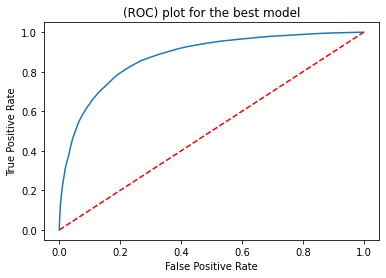

In [20]:
import matplotlib.pyplot as plt



# extract TPR and FPR values from the model
fpr = lr_pipe_2.stages[-1].summary.roc.select('FPR').toPandas()
tpr = lr_pipe_2.stages[-1].summary.roc.select('TPR').toPandas()
#print(fpr.head())
#print(tpr.head())


plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.title("(ROC) plot for the best model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");
plt.show()
display()



ROC curve summarizes trade-off between the true positive rate vs false positive rate for a predictive model using different probability thresholds.
The higher the AUC, the better the model is at predicting correctly. ROC curve is used when labels are balanced between each class.



 Using the logistic regression summary object contained in the linear regression object within lr_pipe_2, create a precision recall plot. Similar to the `roc` object which is available in the logistic regression summary, there is a `pr` object which can be used to help create a precision / recall curve.  Note that the precision recall curve is built using the same high level methodology as the ROC curve, but using different metrics calculated from the confusion matrix.  If you understand how a ROC curve is built, you understand how a precision / recall curve is built.

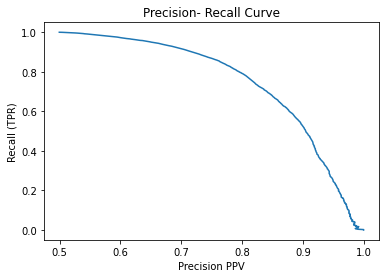

In [21]:

precision_recall=lr_pipe_2.stages[-1].summary.pr.toPandas()
plt.plot(precision_recall['precision'],precision_recall['recall'])
plt.title("Precision- Recall Curve")
plt.xlabel("Precision PPV")
plt.ylabel("Recall (TPR)");
plt.show()
display()
#precision_recall


Precision-Recall curve summarizes trade-off between true positive rate and the positive predictive value for using different probability thresholds. Precision-recall curves are appropriate when labels are imbalanced between each class.

Y axis with True Positice rate (also called Recall) is common between the 2 curves.
Wheres x axis is different. With Precision-Recall curve Precision (also called positive predictive value) was used, whereas, in AUC curve false positive rate was used.




## Plotting the ROC and PR curves using test data

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
[0.9991925716592652, 0.988897860314897, 0.9636657246669358, 0.7981429148163101, 0.18389180460234153, 0.015542995559144126, 0.003835284618490109]
[0.9910820451843044, 0.8777249306381292, 0.6860879904875148, 0.2822037257233452, 0.018628616726119707, 0.0009908838684106192, 0.0]
[0.49763937719738827, 0.5279761270382607, 0.5886406844106464, 0.7767325180307306, 0.981378763866878, 0.9989917322040734, 1.0]


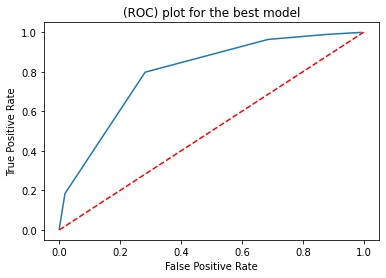

In [22]:

#lr_pipe_2.stages[-1].threshold

en_lr_ex = LogisticRegression().\
        setLabelCol('target').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setThreshold(.1).\
        setElasticNetParam(alpha_par)



lr_pipe_ex = Pipeline(stages=[tweets_pre_proc_pipe, en_lr_ex])
grid = ParamGridBuilder().\
    addGrid(en_lr_ex.threshold, [.1,.25,.35,.5,.7,.85,.9]).\
    build()

all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    #Using test data to compute statistical measures of the performance
    model = lr_pipe_ex.fit(training_df, grid[j]).transform(testing_df)
    all_models.append(model)
#tpr= TP/T
tpr_ex = [ m[m.target==1].select(F.sum(F.expr('float(prediction == 1 )'))).collect()[0][0]/m[m.target==1].count() for m in all_models]
#fpr=1-TN/N
fpr_ex = [ 1- m[m.target==0].select(F.sum(F.expr('float(prediction == 0 )'))).collect()[0][0]/m[m.target==0].count() for m in all_models]
#ppv=TP/ (TP+FP)
ppv_ex = [ m[m.target==1].count()/(m[m.target==1].count()+m[m.target==0].select(F.sum(F.expr('float(prediction == 1 )'))).collect()[0][0])
 for m in all_models]

print(tpr_ex)
print(fpr_ex)
print(ppv_ex)


plt.plot(fpr_ex,tpr_ex)
plt.plot([0, 1], [0, 1], 'r--')
plt.title("(ROC) plot for the best model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate");
plt.show()
display()

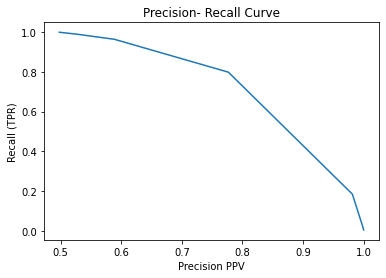

In [23]:

plt.plot(ppv_ex,tpr_ex)
plt.title("Precision- Recall Curve")
plt.xlabel("Precision PPV")
plt.ylabel("Recall (TPR)");
plt.show()
display()
